# Time Series Frequency Modelling with Fourier Transform and TimeGPT-1
Real-world time series often consist of patterns that occur **periodically** and at **multiple scales**. This is because Nature is inherently rhythmic, and so are human behaviors.

For example:
* We wake up **every day** at a certain time
* We celebrate **our birthday** after 365 days
* We relax **every sunday**.

For this reason, as we are dealing with time series with clear and evident patterns, it usually makes sense to treat the different **time scales** and analyze them one at a time. This allows us to analyze the problems at different levels and uncovers a deeper understanding of the phenomenon that the time series represents. 

A very famous mathematical transformation that allows us to decompose a multi-level pattern time series is known as the **Fourier Transform** (FT). The FT transforms a time-domain signal into its frequency components, revealing the underlying periodicities that drive the observed patterns. This method is very well known and frequently used in signal processing engineering.

In this blog post, we will combine the intuition of the Fourier Transform with the power of [TimeGPT-1](https://www.nixtla.io/docs), a state-of-the-art foundation model for time series forecasting developed by Nixtla, capable of modelling time series with a very high degree of accuracy. TimeGPT-1 will be thus adopted at different scales and will be used to model all the sub-patterns of our time series.

## About the Fourier Transform


[Fourier Transform](https://www.sciencedirect.com/topics/engineering/fourier-transform) that allows to explore the time series in the **frequency domain**. Let me explain this further.

You might be familiar with the equation of a **sine wave**:
![Alt text](images/sinewave.svg)

In this equation the frequency, f, is a scalar value. For example, if
* f = 1 the wave completes one full cycle per time unit.
* f = 2 the wave completes two full cycles per time unit, and so on.

A real world time series might be composed of multiple **sine waves**. For example, a time series composed of m sine waves is represented by the equation: 

![Alt text](images/sum_of_sines.svg)

The Fourier Transform takes this complex time series, made up of many overlapping waves, and breaks it down into a set of sine and cosine components, each with its own frequency and amplitude.



In [1]:
from data import * 

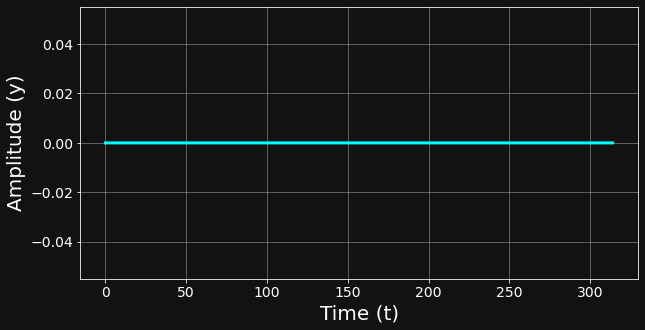

In [2]:
data = Data()
data.plot_time_series()